In [1]:
import gurobipy as gp
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

<gurobipy.Env, Parameter changes: OutputFlag=0>

In [2]:
import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'

import subprocess
from dsd import fibheap, dsp
import dsd
from scipy import optimize
import networkx as nx
import numpy as np
import time
import warnings
import math, json
from collections import defaultdict
warnings.filterwarnings('ignore')

# Data loading

## read graph

In [3]:
AE = pickle.load(open('data/dblp/authorsAreas.pickle','rb'))
mp = 0
valid_authors = dict() # Name and label
total_ev = np.array([0, 0, 0, 0, 0, 0])
for a,ev in AE.items():
    total_ev += np.array(ev)
for a,ev in AE.items():
    #total_ev += np.array(ev)
    if sum(ev) < 3:
        continue
    if sum(ev) == 3 and min(ev) > 1:
        valid_authors[e] = np.argmax(ev)
    else:
        max_val = max(ev)
        max_arg = - 1
        minRepr = sum(total_ev) + 1
        for i,num in enumerate(ev):
            if num == max_val and total_ev[i] < minRepr:
                max_arg = i
                minRepr = total_ev[i]
        valid_authors[a] = max_arg

In [4]:
G = nx.Graph()
nodes = dict()
inv_idx = dict()
edges = defaultdict(set)
f = open('data/dblp/dblp.json','r')
data = json.load(f)
k = 0
total_edges = 0
for _,authors,_ in data:
    l = len(authors)
    for i in range(l):
        i_aut = authors[i]
        if i_aut not in valid_authors:
            continue
        for j in range(i+1):
            j_aut = authors[j]
            if j_aut not in valid_authors:
                continue
            if i_aut==j_aut:
                continue
            G.add_edge(i_aut,j_aut)
# print("Nodes: ", k, " Edges: ", G.number_of_edges())

In [255]:

# exact_S, opt_d = dsd.exact_densest(G)

In [5]:
inv_map = {}
nmap = {}
for i in G.nodes():
    nmap[i] = k
    inv_map[k] = i
    k += 1
G = nx.relabel_nodes(G, nmap)

## Construct node features

In [18]:
n_a = []
for i in range(G.number_of_nodes()):
    n_a.append(AE[inv_map[i]])

In [19]:
n_a = np.array(np.log(1+np.array(n_a)))

## Graph statistics

In [7]:
G.number_of_nodes(), G.number_of_edges()

(25714, 152100)

# Run experiment

-100 !!!!
26.0 53 -3.5849056603773586


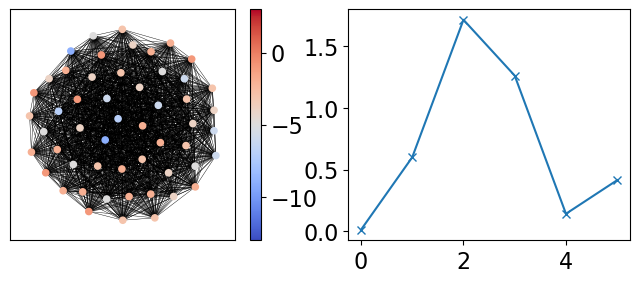

26.0 53 -2.452830188679245


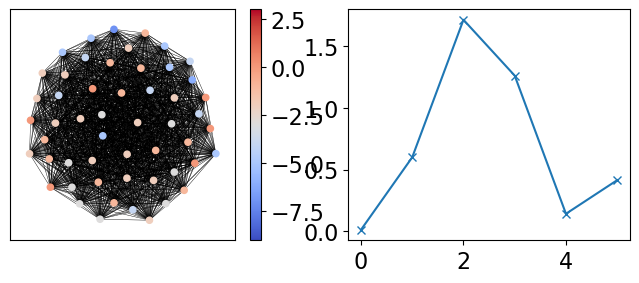

26.0 53 -0.7169811320754716


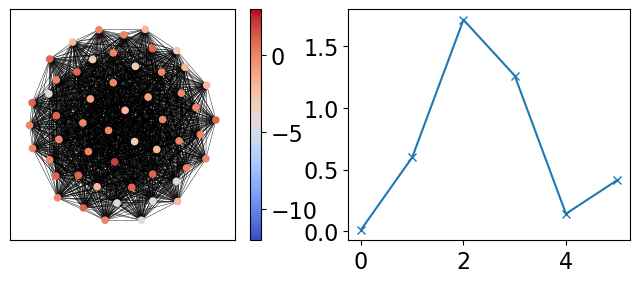

26.0 53 -1.169811320754717


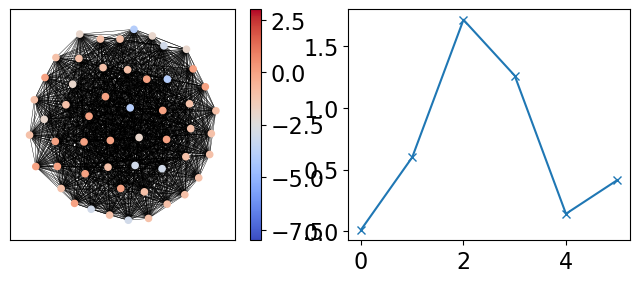

26.0 53 -3.3207547169811322


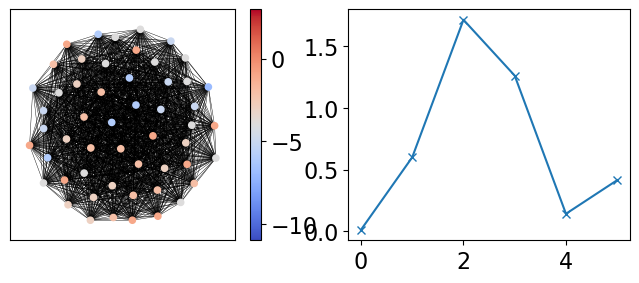

26.0 53 -2.8679245283018866


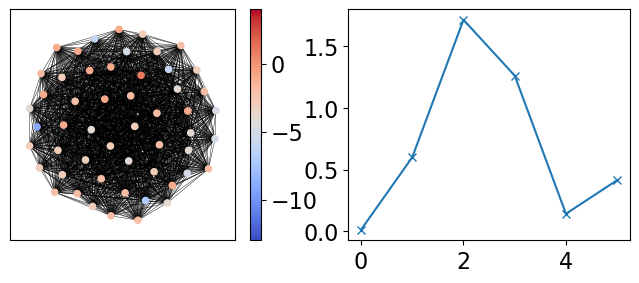

318
53


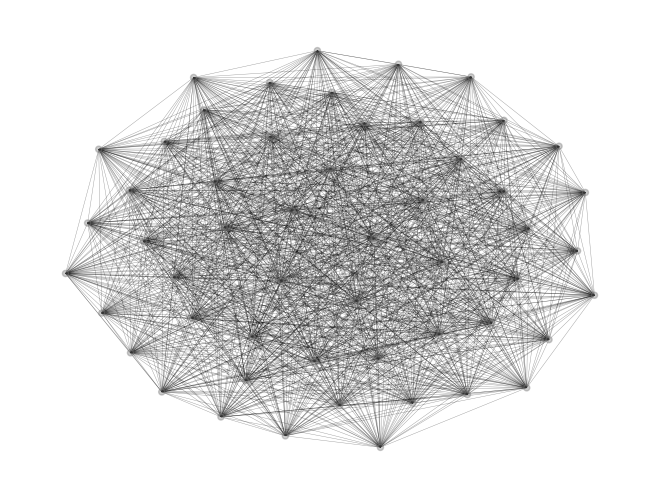

-1 !!!!
17.8868778280543 221 -0.9909502262443439


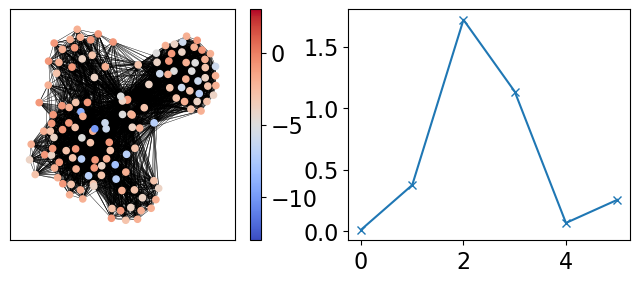

21.333333333333332 87 -0.9540229885057471


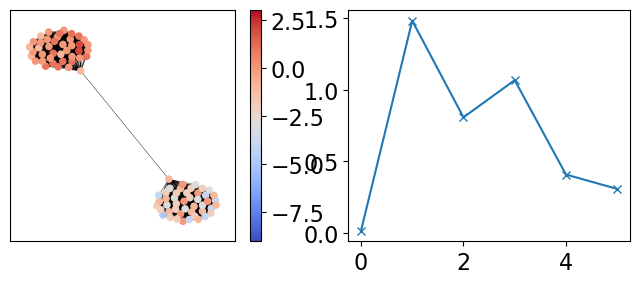

26.0 53 -0.7169811320754716


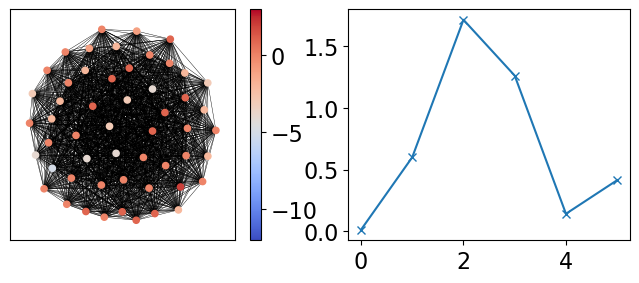

27.09917355371901 121 -0.9256198347107438


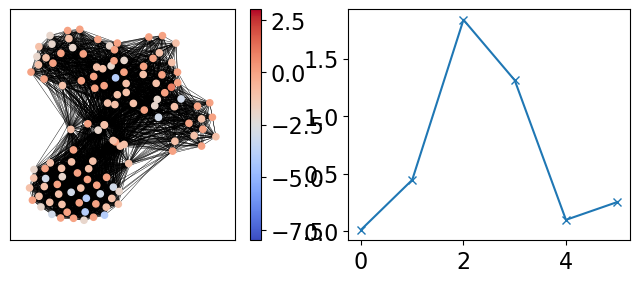

15.410423452768729 307 -0.993485342019544


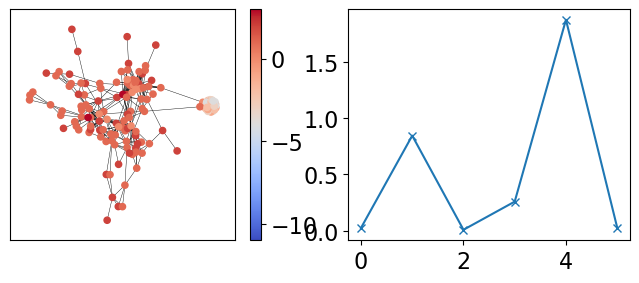

19.64835164835165 182 -0.9835164835164835


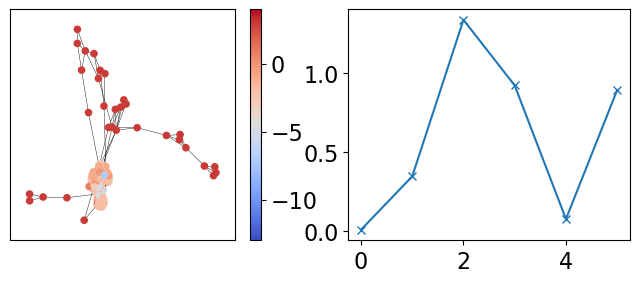

716
335


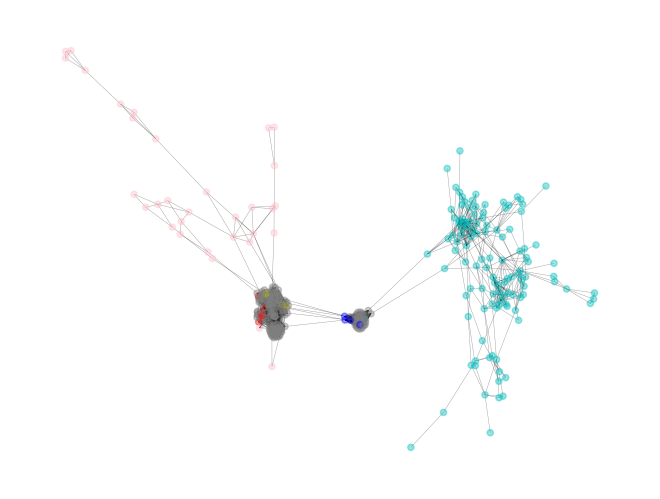

0 !!!!
13.281976744186046 344 0.0029069767441860465


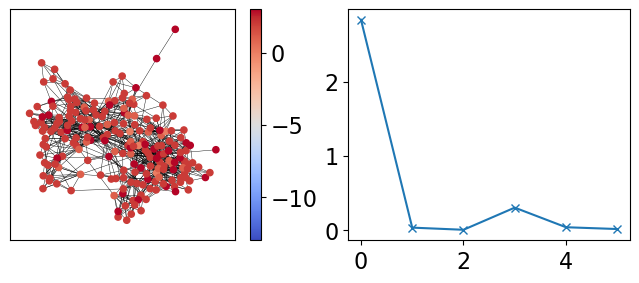

20.0 41 0.21951219512195122


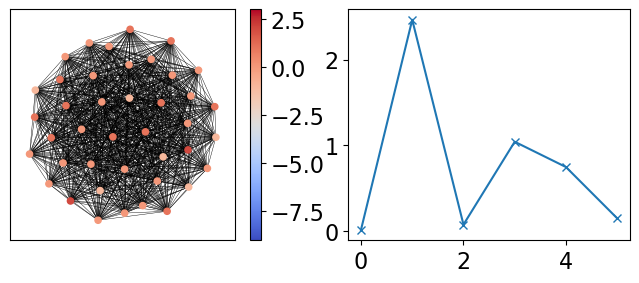

25.087719298245613 171 0.011695906432748537


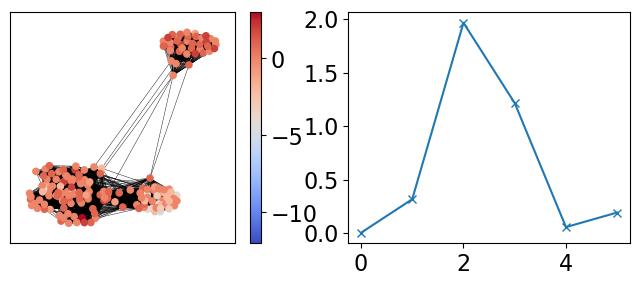

20.82758620689655 145 0.006896551724137931


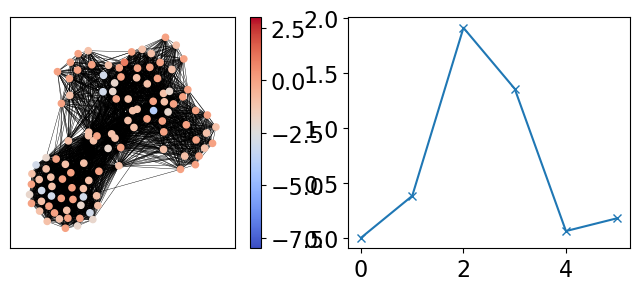

8.96808510638298 282 0.0035460992907801418


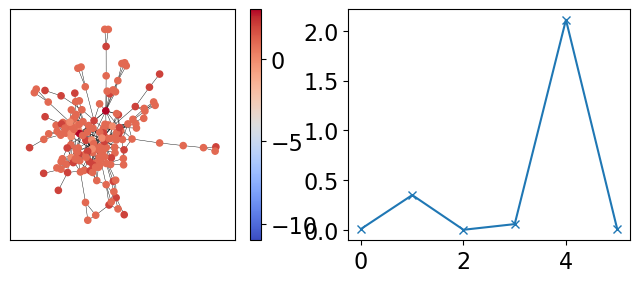

15.00413223140496 242 0.004132231404958678


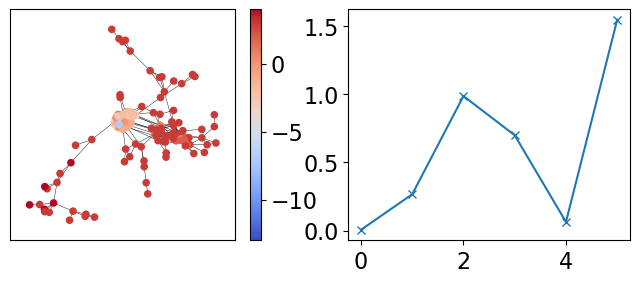

913
682


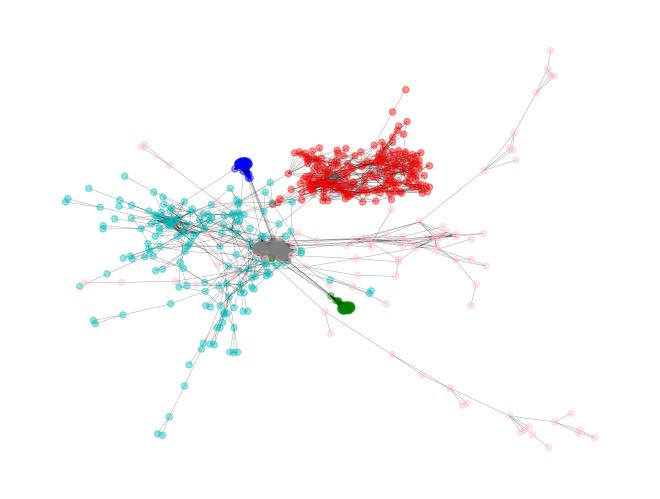

1.5 !!!!
5.549019607843137 255 1.5098039215686274


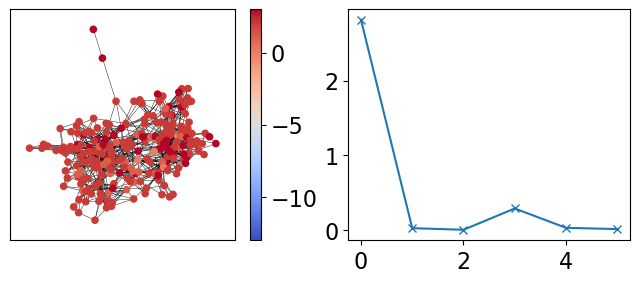

9.679611650485437 103 1.5048543689320388


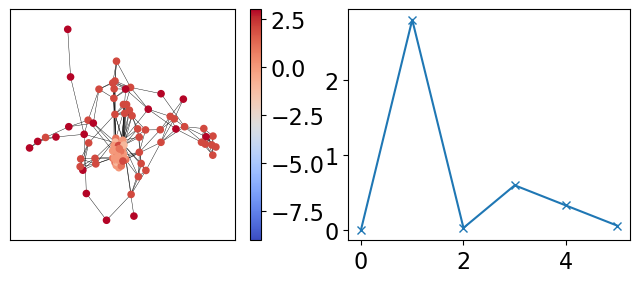

5.0 11 1.5454545454545454


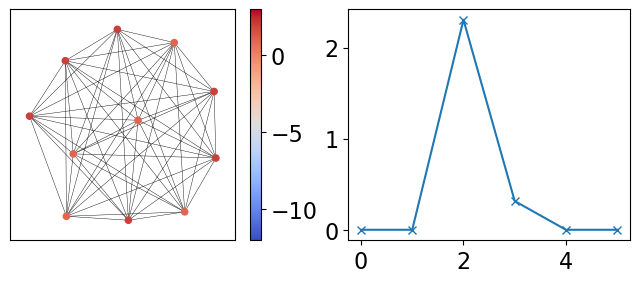

10.20138888888889 144 1.5069444444444444


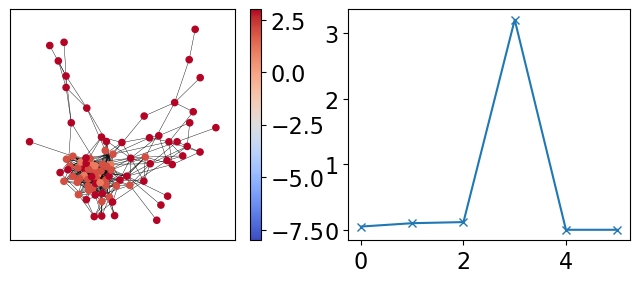

2.6493506493506493 77 1.5194805194805194


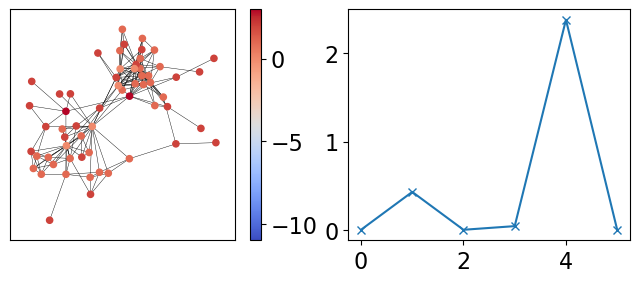

7.497757847533633 223 1.5022421524663676


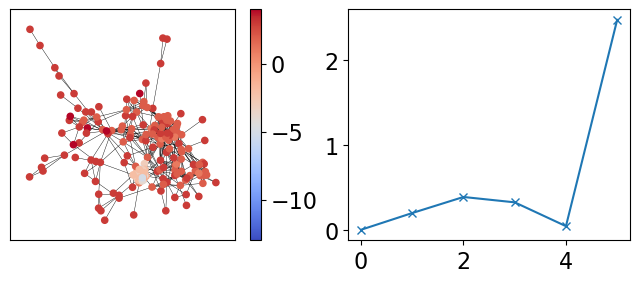

682
682


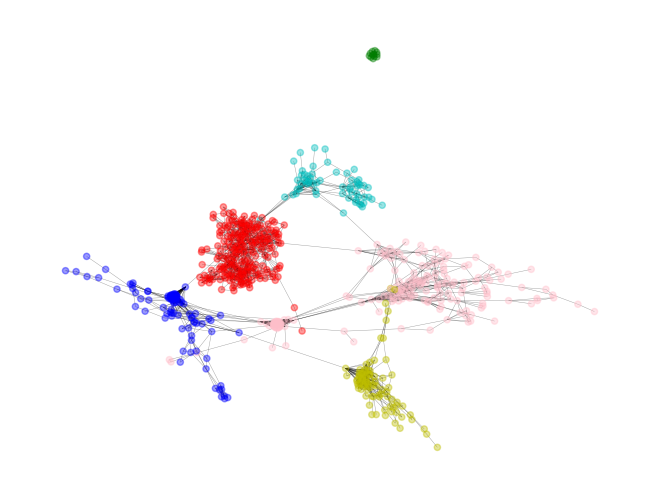

In [25]:
us = []
for thre in [-100, -1, 0, 1.5]:
    print(thre, "!!!!")
    subs = []
    for area in range(6):
        f = open(f'data/dblp/{area}_only.txt','w')
        query = np.array([-1,-1.,-1.,-1,-1,-1])
        query[area] = 1
        f.write(str(G.number_of_nodes())+' '+str(G.number_of_edges())+'\n')
        nws = []
        for i in G.nodes():
            dot_p = np.sum(n_a[i]*query)
            f.write(str(int(dot_p))+'\n')
            nws.append(int(dot_p))

        for e in G.edges():
            if e[0]==e[1]:
                print("!!!")
            else:
                f.write(str(e[0])+' '+str(e[1])+' '+'1\n')

        f.close()
        nws = np.array(nws)
        st = time.time()
        fout = open(f"tmp_dblp_{area}_peel.log", "w")
        acc = 1000 if thre==-100 else 100
        subprocess.run(["./src/ip", f"{thre}", f"{str(acc)}", "1000", f"data/dblp/{area}_only.txt", f"dblp_output_{area}.peel"],
            stdout = fout) 
        finish_time = time.time()-st
        f = open(f"dblp_output_{area}.peel","r")
        uids = []
        for line in f:
            uids.append(int(line.strip()))
        d = G.subgraph(uids).number_of_edges()/len(uids)
        print(d, len(uids),np.average(nws[np.array(uids)]))
        ccs = sorted(nx.connected_components(G.subgraph(uids)), key=len)
        uids = list(ccs[-1])
        plt.figure(figsize=(8,3))
        plt.subplot(1,2,1)
        vmax, vmin = max(nws), min(nws)
        cmap = plt.cm.coolwarm
        color = []
        for i in G.subgraph(uids).nodes():
            color.append(nws[i])

        pos = nx.spring_layout(G.subgraph(uids))
        pathcollection = nx.draw_networkx(G.subgraph(uids), pos, with_labels=False, node_color=color, node_size=20, cmap=cmap, vmin=vmin, vmax=vmax, width=0.3)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm)

        plt.subplot(1,2,2)

        plt.plot(np.average(n_a[np.array(uids)],axis=0), marker='x')
        plt.show()

        subs.append(uids)

    union = []
    for i in range(6):
        union = union + subs[i]
    print(len(union))
    union = set(union)
    print(len(union))
    us.append(union)
    c_map = {}
    cs = ['r','b','g','y','c','pink']
    for i in range(6):
        for j in subs[i]:
            if j in c_map:
                c_map[j] = 'grey'
            else:
                c_map[j]=cs[i]
    vis_g = G.subgraph(union)
    c = []
    for v in vis_g.nodes():
        c.append(c_map[v])
    nx.draw(vis_g, with_labels=False, node_color=c, node_size=20, cmap=cmap, vmin=vmin, vmax=vmax, width=0.3, alpha=0.4)
    plt.tight_layout()
    plt.savefig(f'dblp_{thre}_union.png')
    plt.show()

## Researchers in different subgraphs found

### Figure 3(a)

In [27]:
', '.join([inv_map[i] for i in sorted(us[0], key=lambda x:np.sum(AE[inv_map[x]]), reverse=True)])

'Luc Van Gool, Jian Sun 0001, Xian-Sheng Hua 0001, Fahad Shahbaz Khan, Radu Timofte, Chengjie Wang, Li Wang, Ying Tai, Fei Wang, Shuaicheng Liu, Chao Chen, Jinshan Pan, Hao Li, Salman H. Khan 0001, Munawar Hayat, Jie Liu, Yu Qiao, Chao Dong, Tao Yang, Lefei Zhang, Jun Chen, Xuansong Xie, Jun Liu, Haoqiang Fan, Ding Liu, Weiran Wang, Jie Tang, Jing Liu, Gangshan Wu, Kai Zhang 0008, Lei Sun, Yawei Li, Xin Li 0005, Peiran Ren, Lu Tian, Yi Zhu, Donghao Luo, Yingqi Liu, Xiangyu Chen, Yan Wang, Yufei Wang, Meiguang Jin, Lei Yu, Syed Waqas Zamir, Wei Xiong 0008, Zhizhong Zhang, Aditya Arora, Xinyu Chen, Chuming Lin, Huan Liu, Qi Wu, Shi Chen, Xiaozhong Ji'

### Leading Researchers in each area in Figure 3(d)

In [30]:
area_list = 'Theory, Data Mining, Image Processing, Learning, Data Management,  Networking'.split(', ')
for idx in range(len(cs)):
    c = cs[idx]
    print(area_list[idx], ":", ', '.join([inv_map[i] for i in sorted(us[3], key=lambda x:np.sum(AE[inv_map[x]]), reverse=True) if c_map[i]==c][:5]))

Theory : Aaron Sidford, Yin Tat Lee, Anupam Gupta 0001, Daniel Lokshtanov, Saket Saurabh 0001
Data Mining : Jiawei Han 0001, Jiliang Tang, Maarten de Rijke, Hongzhi Yin, Yiqun Liu 0001
Image Processing : James M. Rehg, Yoichi Sato, Jianbo Shi, Hao Jiang 0007, Dima Damen
Learning : Yoshua Bengio, Sergey Levine, Pieter Abbeel, Doina Precup, Rémi Munos
Data Management : Guoliang Li 0001, Samuel Madden, Mohamed F. Mokbel, Anastasia Ailamaki, Nan Tang 0001
 Networking : Zhu Han 0001, Yunhao Liu 0001, Xiang-Yang Li 0001, Qian Zhang 0001, Victor C. M. Leung
